In [14]:
#########################################
#Task#
###########################################

# Take your favourite data class of MNIST from one of the past sheets. Write a classification model of
# your choice and fit it with the in-built fit function model.fit(). Then write a custom training loop
# and fit your model with it. Compare the performance and timing.
# Consider using @tf.function

In [15]:
#########################################
#Import modules#
###########################################

import tensorflow as tf


from tensorflow.python.keras import Input
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K


from tensorflow.keras.losses import categorical_crossentropy #loss function

import time as time

In [16]:
#########################################
#Parameters for both models#
###########################################


num_classes = 10            #number of classes for the classifier

layer_dimensions=[128,64]   #dimensions of the sequential hidden Dense layers
activation="relu"           #activation of the hidden Dense layers

batch_size=64
epochs=20


optimizer=Adam(learning_rate=0.0001)


#########################################
#Parameters for standard models#
###########################################


loss_standard="categorical_crossentropy"


#########################################
#Parameters for custom models#
###########################################


loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

train_accuracy_metric=tf.keras.metrics.CategoricalAccuracy()
validation_accuracy_metric=tf.keras.metrics.CategoricalAccuracy()



In [17]:
#########################################
#create data#
###########################################

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)

y_test2=y_test
y_test = to_categorical(y_test, num_classes)


#making batches for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(batch_size)


In [18]:
#########################################
#define plot functions#
###########################################


def plot_loss(history, model_name="Model"):
    """Plots the losses achieved during the fitting.
    """
    plt.plot(np.arange(1,len(history['loss'])+1),history['loss'])
    plt.plot(np.arange(1,len(history['loss'])+1),history['val_loss'])
    plt.ylabel('Model Losses')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    
    plt.title('Losses of {model_name}'.format(model_name=model_name))
    plt.show()

def plot_accuracy(history, model_name="Model"):
    """Plots the accuracies achieved during the fitting.
    """
    plt.plot(np.arange(1,len(history['accuracy'])+1),history['accuracy'])
    plt.plot(np.arange(1,len(history['accuracy'])+1),history['val_accuracy'])
    plt.ylabel('Model Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    
    plt.title('Accuracies of {model_name}'.format(model_name=model_name))
    plt.show()


In [19]:
#########################################
#build model1 for standard fit#
###########################################


inp=Input(shape= x_train[0].shape)
x=Flatten()(inp)   

for dimension in layer_dimensions:
    x=Dense(dimension,activation=activation)(x)   #hidden Dense layers
    
out=Dense(num_classes,activation="softmax")(x)


model1=Model(inputs=inp,outputs=out)

model1.compile(loss=loss_standard,optimizer=optimizer,metrics=["accuracy"])

model1.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [20]:
#########################################
# standard fit of model1#
###########################################


start_time=time.time()

history1=model1.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test))
history1=history1.history

end_time=time.time()
execution_time1=end_time-start_time

print("")
print("###############################")
print("")
print("Execution time: "+str(execution_time1))

Epoch 1/20
938/938 [==============================] - 1s 1ms/step - loss: 0.7335 - accuracy: 0.8106 - val_loss: 0.3294 - val_accuracy: 0.9090
Epoch 2/20
938/938 [==============================] - 1s 1ms/step - loss: 0.2884 - accuracy: 0.9204 - val_loss: 0.2446 - val_accuracy: 0.9306

In [21]:
#########################################
#build model2 for custom fit#
###########################################

inp=Input(shape= x_train[0].shape)
x=Flatten()(inp)   

for dimension in layer_dimensions:
    x=Dense(dimension,activation=activation)(x)   #hidden Dense layers
    
out=Dense(num_classes,activation="softmax")(x)

model2=Model(inputs=inp,outputs=out)

model2.summary()


###########################################################

@tf.function  
def train_iteration(x_train_batch,y_train_batch,training=True):
    """iteration of fit for fit_data"""


    with tf.GradientTape() as tape:
        #record the gradients on "tape"

        logits = model2(x_train_batch, training=training)  # Logits for a batch

        # Compute the loss value for this minibatch.
        loss_value = loss_function(y_train_batch, logits)



    #retrieve gradients
    grads = tape.gradient(loss_value, model2.trainable_weights)

    #apply gradient descent update
    optimizer.apply_gradients(zip(grads, model2.trainable_weights))
    
###################################################

@tf.function
def get_test_accuracy(x_test_batch, y_test_batch):
    """used to calculate validation accuracy"""
    val_logits = model2(x_test_batch, training=False)
    validation_accuracy_metric.update_state(y_test_batch, val_logits)
    
######################################################

@tf.function
def get_train_accuracy(x_train_batch, y_train_batch):
    """used to calculate train accuracy"""
    train_logits = model2(x_train_batch, training=False)
    train_accuracy_metric.update_state(y_train_batch, train_logits)
        

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [22]:
#########################################
# custom fit of model2#
###########################################
start_time=time.time()




#history of accuracy
train_history=[]
validation_history=[]






#going through epochs and batches
for epoch in range(epochs):
    epoch+=1
    print("Epoch: %d" % (epoch,))


    for step, (x_train_batch,y_train_batch) in enumerate(train_dataset):
        train_iteration(x_train_batch,y_train_batch)

    
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        get_test_accuracy(x_batch_val, y_batch_val)
        
    # Run a trainig loop at the end of each epoch.
    for x_batch_train, y_batch_train in train_dataset:
        get_train_accuracy(x_batch_train, y_batch_train)
 
    val_accuracy = validation_accuracy_metric.result()
    train_accuracy = train_accuracy_metric.result()
    
    train_history.append(float(train_accuracy))
    validation_history.append(float(val_accuracy))
    
    # Reset training metrics at the end of each epoch
    train_accuracy_metric.reset_states()
    validation_accuracy_metric.reset_states()
    
    print("Training accuracy: %.4f" % float(train_accuracy))
    print("Validation accuracy: %.4f" % float(val_accuracy))
    
    
    
#combine history
history2={"accuracy":train_history,"val_accuracy":validation_history}
    
    
    
    
end_time=time.time()
execution_time2=end_time-start_time

print("")
print("###############################")
print("")
print("Execution time: "+str(execution_time2))

Epoch: 1
Training accuracy: 0.9208
Validation accuracy: 0.9219
Epoch: 2
Training accuracy: 0.9343
Validation accuracy: 0.9318
Epoch: 3
Training accuracy: 0.9419
Validation accuracy: 0.9394
Epoch: 4
Training accuracy: 0.9475
Validation accuracy: 0.9424
Epoch: 5
Training accuracy: 0.9513
Validation accuracy: 0.9472
Epoch: 6
Training accuracy: 0.9543
Validation accuracy: 0.9484
Epoch: 7
Training accuracy: 0.9571
Validation accuracy: 0.9517
Epoch: 8
Training accuracy: 0.9602
Validation accuracy: 0.9546
Epoch: 9
Training accuracy: 0.9621
Validation accuracy: 0.9555
Epoch: 10
Training accuracy: 0.9641
Validation accuracy: 0.9563
Epoch: 11
Training accuracy: 0.9663
Validation accuracy: 0.9586
Epoch: 12
Training accuracy: 0.9674
Validation accuracy: 0.9600
Epoch: 13
Training accuracy: 0.9683
Validation accuracy: 0.9614
Epoch: 14
Training accuracy: 0.9702
Validation accuracy: 0.9620
Epoch: 15
Training accuracy: 0.9710
Validation accuracy: 0.9629
Epoch: 16
Training accuracy: 0.9719
Validation ac

In [23]:
#Comparision:

print("Final accuracies:")
print("")
print("Standard Model:")
print("Train accuracy: "+str(history1["accuracy"][-1]))
print("Test accuracy: "+str(history1["val_accuracy"][-1]))
print("Execution time: "+str(execution_time1))
print("")
print("Custom_Model:")
print("Train accuracy: "+str(history2["accuracy"][-1]))
print("Test accuracy: "+str(history2["val_accuracy"][-1]))
print("Execution time: "+str(execution_time2))

Final accuracies:

Standard Model:
Train accuracy: 0.9865666627883911
Test accuracy: 0.9732000231742859
Execution time: 20.023746252059937

Custom_Model:
Train accuracy: 0.9765499830245972
Test accuracy: 0.965399980545044
Execution time: 44.81777787208557


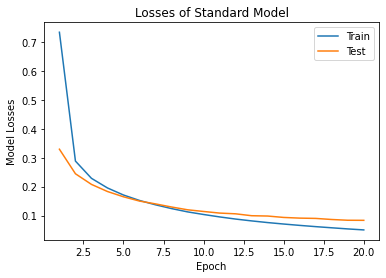

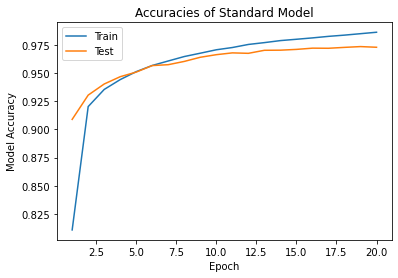

In [24]:
plot_loss(history1, model_name="Standard Model")
plot_accuracy(history1, model_name="Standard Model")

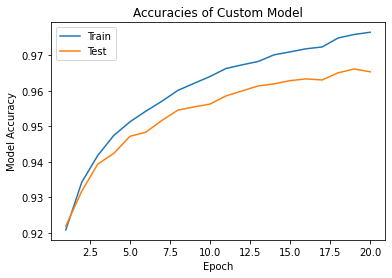

In [25]:
plot_accuracy(history2, model_name="Custom Model")

In [26]:
#for my run it seems that both accuracies are higher with the custom model but only marginally.
#both are pretty ok with around 98% test accuracy and 97% validation accuracy

#the execution time is about 15 percent faster for me with the custom model at 47 to 42 seconds